# Viga del ejemplo 3

|Quién | Correo | Fecha | Qué hizo |
| ---  | ---    | ---   | ---      |
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co> | Febrero 12, 2024  | Conversión de código de Maxima a Python |

Calcule los diagramas de fuerza cortante, momento flector, ángulo de giro y deflexión vertical de la viga mostrada en la figura:

<img src="viga_3.png" width="600">

In [1]:
from sympy import init_printing, latex, DiracDelta, Piecewise, integrate, symbols, Eq, plot, piecewise_fold, solve, Interval, Rational, sets
from sympy.abc import x

# Para imprimir bonito
init_printing()
from IPython.display import Math                 
def imprimir (texto1, variable, texto2=""):
    return Math(texto1 +  rf'{latex(variable)}' + texto2)

Se define una función que hace el código más corto y legible, evitando el uso de las [funciones G de Meijerg](https://en.wikipedia.org/wiki/Meijer_G-function):

In [2]:
integre = lambda f, x : integrate(f, x, meijerg=False)

Se definen las cargas distribuidas de acuerdo con la tabla 10.3 del `main.pdf`

In [3]:
# Caso 2: carga puntual 
qpunt = lambda p,a : p*DiracDelta(x-a)

# Caso 5: carga distribuida variable 
qdist = lambda f,a,b : Piecewise((f, (a < x) & (x < b)), (0, True))

# Funcion rectangular: si x>a y x<b retorne 1 sino retorne 0   
rect = lambda a,b : Piecewise((1, (a < x) & (x < b)), (0, True))

Se define la geometría de la viga y las propiedades del material:

In [4]:
L = 19              # [m]   Longitud de la viga
b = Rational(1, 10) # [m]   Ancho de la viga
h = Rational(3, 10) # [m]   Altura de la viga
E = 210_000_000     # [kPa] Módulo de elasticidad de la viga
I = (b*h*h*h)/12    # [m⁴]  Momento de inercia en z    

Se especifica la función de carga $q(x)$:

In [5]:
q = qdist(-12,10,16) + qpunt(-30,5)

Se resuelve la ecuación diferencial tramo por tramo:

In [6]:
# Tramo 1: de x=0m a x=10m
C1_1, C1_2, C1_3, C1_4 = symbols('C1_1 C1_2 C1_3 C1_4')
q1 = q*rect(0,10)              # restriccion de q al tramo 1   
V1 = integre(q1, x)       + C1_1
M1 = integre(V1, x)       + C1_2
t1 = integre(M1/(E*I), x) + C1_3
v1 = integre(t1, x)       + C1_4

# Tramo 2: de x=10m a x=16m
C2_1, C2_2, C2_3, C2_4 = symbols('C2_1 C2_2 C2_3 C2_4')
q2 = q*rect(10,16)             # restriccion de q al tramo 2   
V2 = integre(q2, x)       + C2_1
M2 = integre(V2, x)       + C2_2
t2 = integre(M2/(E*I), x) + C2_3
v2 = integre(t2, x)       + C2_4

# Tramo 3: de x=16m a x=19m
C3_1, C3_2, C3_3, C3_4 = symbols('C3_1 C3_2 C3_3 C3_4')
q3 = q*rect(16,19)             # restriccion de q al tramo 3   
V3 = integre(q3, x)       + C3_1
M3 = integre(V3, x)       + C3_2
t3 = integre(M3/(E*I), x) + C3_3
v3 = integre(t3, x)       + C3_4

Se encuentran las constantes de integración que satisfacen las condiciones de frontera:

In [7]:
sol = solve([ 
    Eq(v1.subs(x,0), 0),              # despl vert en apoyo en x=0 es 0  
    Eq(t1.subs(x,0), 0),              # theta en apoyo en x=0 es 0       
    
    Eq(v1.subs(x,10), 0),             # despl vert en apoyo en x=10 es 0 
    Eq(v2.subs(x,10), 0),             # despl vert en apoyo en x=10 es 0 
    Eq(t1.subs(x,10), t2.subs(x,10)), # continuidad en theta en x=10     
    Eq(M1.subs(x,10), M2.subs(x,10)), # continuidad en M     en x=10     
    
    Eq(v2.subs(x,16), 0),             # despl vert en apoyo en x=16 es 0 
    Eq(v3.subs(x,16), 0),             # despl vert en apoyo en x=16 es 0 
    Eq(t2.subs(x,16), t3.subs(x,16)), # continuidad en theta en x=16     
    Eq(M2.subs(x,16), M3.subs(x,16)), # continuidad en M     en x=16     
    
    Eq(M3.subs(x,19), 0),             # momento flector en x=19 es 0     
    Eq(V3.subs(x,19), 15)             # fuerza cortante en x=19 es 15    
],
[ 
     C1_1, C1_2, C1_3, C1_4, 
     C2_1, C2_2, C2_3, C2_4, 
     C3_1, C3_2, C3_3, C3_4 
])

Se fusionan las fórmulas y se reemplaza el valor de las constantes de integración:

In [8]:
V = (V1*rect(0,10) + V2*rect(10,16) + V3*rect(16,19)).subs(sol)
M = (M1*rect(0,10) + M2*rect(10,16) + M3*rect(16,19)).subs(sol)
t = (t1*rect(0,10) + t2*rect(10,16) + t3*rect(16,19)).subs(sol)
v = (v1*rect(0,10) + v2*rect(10,16) + v3*rect(16,19)).subs(sol)

Se simplifica lo calculado por sympy:

In [9]:
def simplificar(VMtv, fracciones=True):    
    var = piecewise_fold(VMtv.rewrite(Piecewise)).as_expr_set_pairs(Interval(0, L))
    tmp = []
    for fun, interv in var:
        if isinstance(interv, sets.sets.Interval | sets.sets.Union):
            if fracciones:
                tmp.append((fun.nsimplify(), interv.as_relational(x)))
            else:
                tmp.append((fun.evalf(),     interv.as_relational(x)))

    return Piecewise(*tmp)

In [10]:
%%time
V = simplificar(V)

CPU times: user 18.8 s, sys: 39.7 ms, total: 18.8 s
Wall time: 18.8 s


In [11]:
%%time
M = simplificar(M)

CPU times: user 20.2 s, sys: 28 ms, total: 20.2 s
Wall time: 20.6 s


In [12]:
%%time
t = simplificar(t, fracciones=False)

CPU times: user 18.6 s, sys: 24 ms, total: 18.7 s
Wall time: 19.1 s


In [13]:
%%time
v = simplificar(v, fracciones=False)

CPU times: user 20 s, sys: 24 ms, total: 20 s
Wall time: 20.1 s


### Se imprimen los resultados

In [14]:
imprimir("V(x) = ", V)

<IPython.core.display.Math object>

In [15]:
imprimir("M(x) = ", M)

<IPython.core.display.Math object>

In [16]:
imprimir(r"\theta(x) = ", t)

<IPython.core.display.Math object>

In [17]:
imprimir("v(x) = ", v)

<IPython.core.display.Math object>

### Se grafican los resultados 

In [18]:
x_xmin_xmax = (x, 0+0.001, L-0.001)

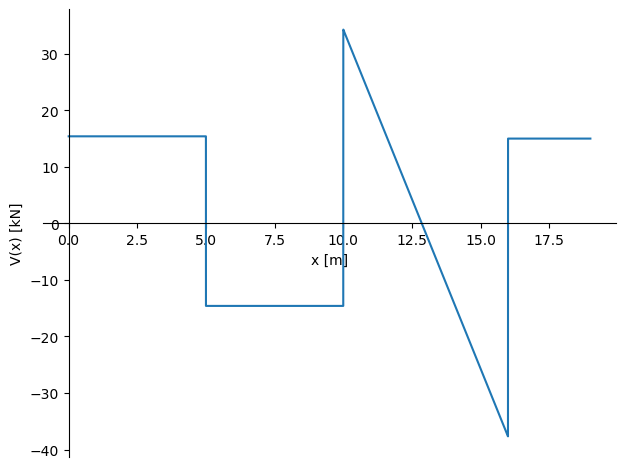

In [19]:
plot(V, x_xmin_xmax, xlabel='x [m]', ylabel='V(x) [kN]')

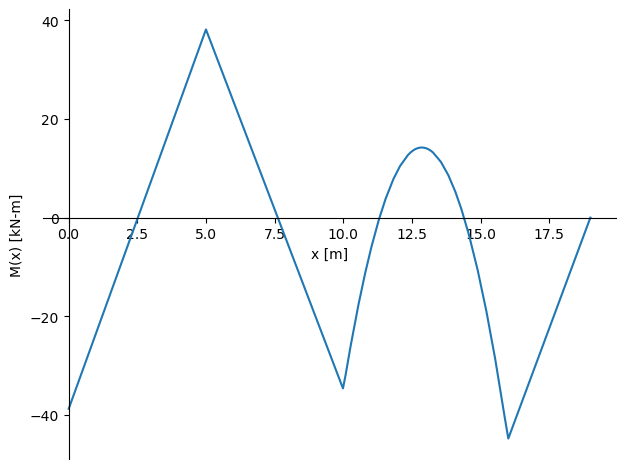

In [20]:
plot(M, x_xmin_xmax, xlabel='x [m]', ylabel='M(x) [kN-m]')

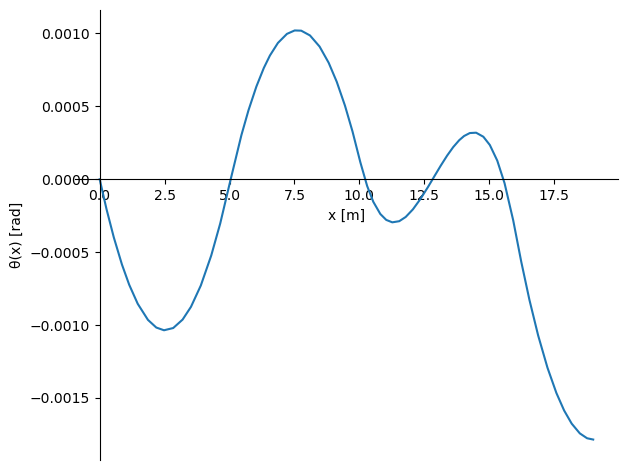

In [21]:
plot(t, x_xmin_xmax, xlabel='x [m]', ylabel='θ(x) [rad]')

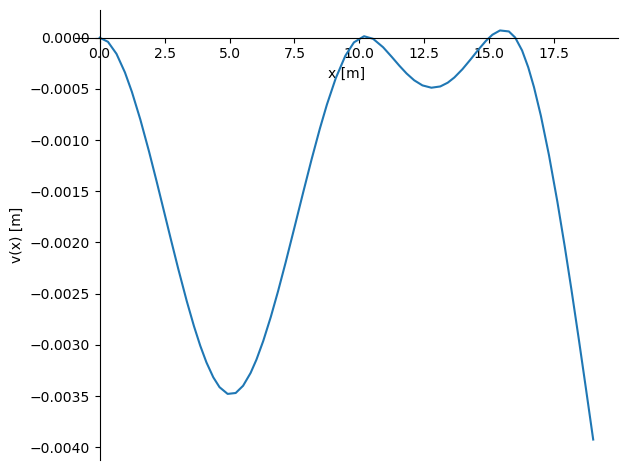

In [22]:
plot(v, x_xmin_xmax, xlabel='x [m]', ylabel='v(x) [m]')

### Se calculan las reacciones en la viga 

In [23]:
print(f" M(x= 0) = {float(       -M1.subs(sol).subs(x, 0))} kN m") # mom en x=0 
print(f"Fy(x= 0) = {float(       +V1.subs(sol).subs(x, 0))} kN")   # Ry en x= 0 
print(f"Fy(x=10) = {float((V2-V1-25).subs(sol).subs(x,10))} kN")   # Ry en x=10 
print(f"Fy(x=16) = {float(   (V3-V2).subs(sol).subs(x,16))} kN")   # Ry en x=16 

 M(x= 0) = 38.833333333333336 kN m
Fy(x= 0) = 15.4 kN
Fy(x=10) = 23.905555555555555 kN
Fy(x=16) = 52.69444444444444 kN
